# Test function on images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib qt

In [2]:
# Unpickle camera calibration data
with open("./camera_cal/calibration_data.p",'rb') as cal_f:
    calibration_data = pickle.load(cal_f) 
mtx = calibration_data['mtx']
dist = calibration_data['dist']

In [3]:
# Load all images
images = glob.glob("./test_images/*.jpg")

In [4]:
images

['./test_images/straight_lines1.jpg',
 './test_images/test2.jpg',
 './test_images/straight_lines2.jpg',
 './test_images/test4.jpg',
 './test_images/test1.jpg',
 './test_images/test6.jpg',
 './test_images/test5.jpg',
 './test_images/test3.jpg']

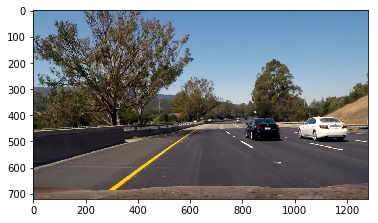

In [158]:
sample_img = mpimg.imread(images[5])
plt.imshow(sample_img)

### 1. Undistort image

In [159]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

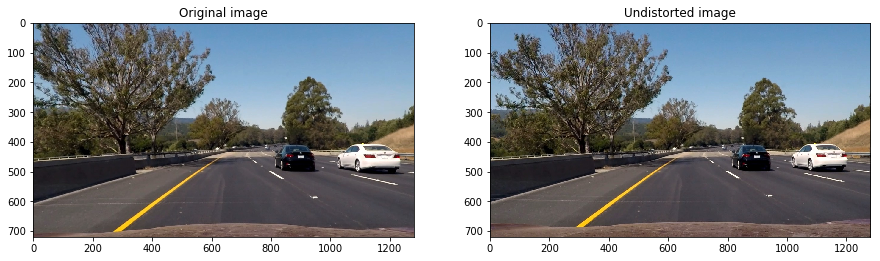

In [160]:
undist_img = undistort(sample_img, mtx, dist)
f, axs = plt.subplots(1,2, figsize=(15,30))
axs[0].imshow(undist_img)
axs[0].set_title("Original image")
axs[1].imshow(sample_img)
axs[1].set_title("Undistorted image")
plt.show()

### 2. Color and Gradient Trasformations

In [161]:
def sobel_filter(img, mode='x', low_thresh=0, high_thresh=255, kernel=3):
    
    # Select mode between gradient in x or y, magnitude and direction
    if mode in ['x','y','mag']:
        
        x_flag = int(mode == 'x')
        y_flag = int(mode == 'y')  
        if x_flag or y_flag:
            sobel_out = cv2.Sobel(img, cv2.CV_64F, x_flag, y_flag, ksize=kernel)
            abs_sobel = np.abs(sobel_out)
        else:
            sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
            sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
            abs_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
        
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
        # Threshold absolute gradient
        sobel_binary = np.zeros_like(scaled_sobel)
        sobel_binary[(scaled_sobel >= low_thresh) & (scaled_sobel <= high_thresh)] = 1
        
    else:
        print("Sobel param 'mode' must correnspond to one of the following values: 'x','y','mag','dir'")
        sys.exit(-1)
    
    return sobel_binary

In [162]:
def color_filter(img, low_thresh, high_thresh):
    color_binary = np.zeros_like(img)
    color_binary[(img >= low_thresh) & (img <= high_thresh)] = 1
    return color_binary

In [163]:
def color_gradient_transform(img, transforms):
    """
    Perform color and gradient transformations and return binary image according to the given thresholds.
    
    The image can undergo both/either one color transformation and/or one Sobel transformation.
    
    It takes as input an RGB image and a list a dictionaries containing the transformation parameters.
    
    Please convert BGR to RGB!
    
    Color Params:
    - type: set to 'color'
    - channel: rgb or hls, gray: 'r','g','b', 'h', 'l','s', 'gray'
    - low_threshold: int in range [0, 255], smaller than high_threshold
    - high_threshold: int in range [0, 255], greate than small_threshold
    
    Sobel Params:
    - s
    - mode: x, y, m, dir
    - channel: rgb or hls 'r','g','b', 'h', 'l','s'
    - low_threshold: int in range [0, 255], smaller than high_threshold
    - high_threshold: int in range [0, 255], greate than small_threshold
    - kernel: kernel size of sobel filter, must be an odd number 
    """
    
    # Compute color transformations only if required by a filter
    img_channel = {}
    channels = set([])
    for params in transforms:
        if params:
            channels = channels.union({params['channel']})
            
    if channels & {'h','l','s'}:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img_channel['h'] = hls[:,:,0]
        img_channel['l'] = hls[:,:,1]
        img_channel['s'] = hls[:,:,2]
        
    if channels & {'r','g','b'}:
        img_channel['r'] = img[:,:,0]
        img_channel['g'] = img[:,:,1]
        img_channel['b'] = img[:,:,2]
        
    if 'gray' in channels:
        img_channel['gray'] = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    imgs = [np.zeros_like(img[:,:,0])]
        
    # Compute required filters
    for params in transforms:
        if params['type'] == 'sobel':
            imgs.append(sobel_filter(img_channel[params['channel']], params['mode'],
                                       params['low_thresh'], params['high_thresh'],
                                       params['kernel']))
        elif params['type'] == 'color':
            imgs.append(color_filter(img_channel[params['channel']],
                                       params['low_thresh'], params['high_thresh']))
        
#     # Combine filters if both are required
#     if colorparams and sobelparams:
#         combi_binary = np.zeros_like(sobel_binary)
#         combi_binary[(sobel_binary == 1) | (color_binary == 1)] = 1
#     elif sobelparams:
#         combi_binary = sobel_binary
#     elif colorparams:
#         combi_binary = color_binary
#     else:
#         combi_binary = np.copy(img)
    combi_binary = imgs
    
    return combi_binary

In [164]:
sobelxparams = {
    'type': 'sobel',
    'channel': 'gray',
    'mode': 'x',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}

sobelyparams = {
    'type': 'sobel',
    'channel': 'gray',
    'mode': 'y',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}

colorparams = {
    'type': 'color',
    'channel': 's',
    'low_thresh': 150,
    'high_thresh': 255
}

cgt_img = color_gradient_transform(undist_img, [sobelxparams, sobelyparams, colorparams])

In [165]:
combi = cgt_img[0]
combi[((cgt_img[1] == 1) & (cgt_img[2] == 1)) | (cgt_img[3] == 1)] = 1

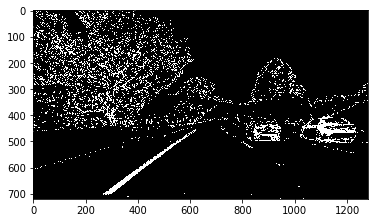

In [166]:
plt.imshow(combi, cmap='gray')
plt.show()

### 3. Perspective transform 

In [167]:
def perspective_transform(img, M, transf=cv2.INTER_LINEAR):
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=transf)
    return warped

Transformation matrix is supposed to be calculated only once since the masking region is always the same

In [168]:
imshape = combi.shape # [y, x]
trap_topwidth = 0.1
trap_bottomwidth = .7
trap_height = 0.37
warp_offset = .57
bottom_offset = 0.08
# src and s
src = np.float32([[imshape[1] * (1 - trap_bottomwidth)/2,imshape[0]*(1 - bottom_offset)],
                  [imshape[1] * (1 - trap_topwidth)/2, imshape[0] * (1 - trap_height)],
                  [imshape[1] * (1 + trap_topwidth)/2, imshape[0] * (1 - trap_height)],
                  [imshape[1] * (1 + trap_bottomwidth)/2, imshape[0]*(1 - bottom_offset)]])
dst = np.float32([[imshape[1] * (1 - warp_offset)/2, imshape[0]*(1 - bottom_offset)],
                  [imshape[1] * (1 - warp_offset)/2, 0],
                  [imshape[1] * (1 + warp_offset)/2, 0],
                  [imshape[1] * (1 + warp_offset)/2, imshape[0]*(1 - bottom_offset)]])

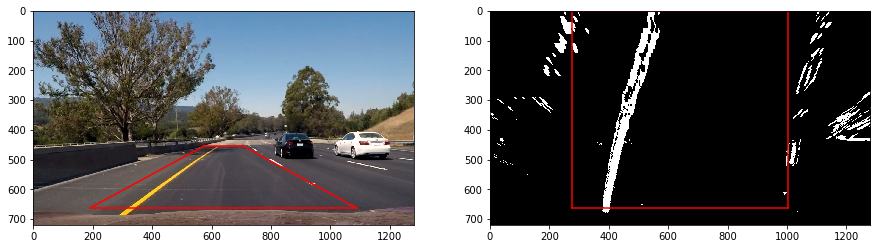

In [169]:
M = cv2.getPerspectiveTransform(src, dst)
warped_img = perspective_transform(combi, M)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,30))

ax1.imshow(sample_img)
ax1.plot(src[0:2,0], src[0:2,1],c='r')
ax1.plot(src[1:3,0], src[1:3,1],c='r')
ax1.plot(src[2:4,0], src[2:4,1],c='r')
ax1.plot(src[[0,3],0], src[[0,3],1],c='r')

ax2.imshow(warped_img, cmap='gray')
ax2.plot(dst[0:2,0], dst[0:2,1],c='r')
ax2.plot(dst[1:3,0], dst[1:3,1],c='r')
ax2.plot(dst[2:4,0], dst[2:4,1],c='r')
ax2.plot(dst[[0,3],0], dst[[0,3],1],c='r')

plt.show()

### Histogram ans sliding window

In [170]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [171]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [172]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

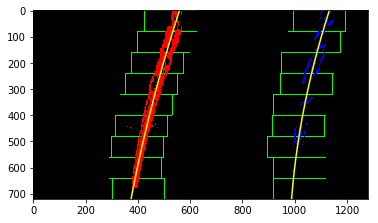

In [173]:
out_img = fit_polynomial(warped_img)
plt.imshow(out_img, cmap='gray')